First, create the model. This must match the model used in the interactive training notebook.

In [6]:
import cv2
import numpy as np

#import tensorflow as tf
from tensorflow import keras

In [7]:
import tensorflow as tf
import pathlib
#model = keras.models.load_model('/home/jetson/jetracer/notebooks/aicarmodel')
converter = tf.lite.TFLiteConverter.from_saved_model('/home/jetson/jetracer/notebooks/aicarmodel')
tflite_models_dir = pathlib.Path.cwd() / "tflite_model_dir"
tflite_models_dir.mkdir(exist_ok=True, parents=True)
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS]
model = converter.convert()

# Load the TFLite model and allocate tensors.    
interpreter = tf.lite.Interpreter(model_content=model)    
interpreter.allocate_tensors()

# Get input and output tensors.    
input_details = interpreter.get_input_details()    
output_details = interpreter.get_output_details()        

def predict(image):
    global interpreter
    global input_details
    global output_details
    
    image = np.array(image, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], image)            
    interpreter.invoke()            
    prediction = interpreter.get_tensor(output_details[0]['index'])
    return prediction


Create the racecar class

In [4]:
from jetracer.nvidia_racecar import NvidiaRacecar

car = NvidiaRacecar()

Create the camera class.

In [5]:
from jetcam.csi_camera import CSICamera

camera = CSICamera(width=224, height=224)

In [33]:
camera.unobserve_all()

del camera

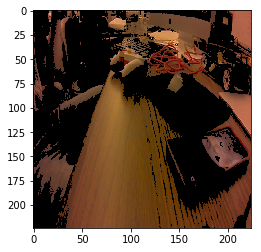

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = camera.read()
plt.imshow(filter_image(image))
plt.show()


Finally, execute the cell below to make the racecar move forward, steering the racecar based on the x value of the apex.

Here are some tips,

* If the car wobbles left and right,  lower the steering gain
* If the car misses turns,  raise the steering gain
* If the car tends right, make the steering bias more negative (in small increments like -0.05)
* If the car tends left, make the steering bias more postive (in small increments +0.05)

In [8]:
def filter_image(image):

  frame = image
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

  # For pulling out all orange colors
  lower_red = np.array([0,80,90])
  upper_red = np.array([255,255,255])

  mask = cv2.inRange(hsv, lower_red, upper_red)
  res = cv2.bitwise_and(frame,frame, mask= mask)
  imageRGB = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  return imageRGB

In [ ]:
model.summary()

In [41]:
from IPython.display import clear_output

THROTTLE_MIN = 0.15
THROTTLE_MAX = 0.2

STEERING_GAIN = 1.0
STEERING_BIAS = -0.4

THROTTLE_GAIN = 0.5

car.throttle = 0.0

while True:
    image = camera.read()
    image = filter_image(image)
    image = np.array([image])
    output = predict(image)
    x = float(output[0][0])/224
    y = float(output[0][1])/224
    
    #print("X VALUE: " + str(x))
    #print("Y VALUE: " + str(y))
    
    rawSteer = abs(x * STEERING_GAIN + STEERING_BIAS)
    car.steering = (x * STEERING_GAIN + STEERING_BIAS)*3
    
    clear_output(wait=True)
    print("RESULT: " + str(abs((rawSteer*THROTTLE_MIN)-THROTTLE_MAX)))
    
    throttle = abs((rawSteer*THROTTLE_MIN)-THROTTLE_MAX)
#     if(rawSteer >= THROTTLE_MAX):
#         rawSteer = THROTTLE_MAX
        
#     if(rawSteer <= THROTTLE_MIN):
#         rawSteer = THROTTLE_MIN
        
    #car.throttle = throttle
    
    
    
#     throt = (y * THROTTLE_GAIN)
#     if(throt >= THROTTLE_MAX):
#         throt = THROTTLE_MAX
        
#     if(throt <= THROTTLE_MIN):
#         throt = THROTTLE_MIN
        
# #     clear_output(wait=True)
# #     print("RESULT: " + str(throt))
    
#     car.throttle = throt
    
    #print("STEERING: " + str(car.steering))
    #print("THROTTLE: " + str(car.throttle))

RESULT: 0.1985099424634661


KeyboardInterrupt: 

In [38]:
car.throttle = 0.0

In [40]:
car.steering = 1.0